In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.pyplot import imread
import h5py
import activationFunctions

In [2]:
def load_data():
    train_dataset = h5py.File("datasets/train_catvnoncat.h5", "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])
    train_set_y_orig = np.array(train_dataset["train_set_y"][:])

    test_dataset = h5py.File("datasets/test_catvnoncat.h5", "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])

    classes = np.array(test_dataset["list_classes"][:])
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

y = 0. It's a non-cat picture.


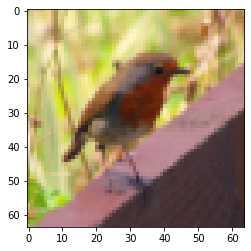

In [4]:
index = 10
plt.imshow(train_x_orig[index])
print(f"y = {str(train_y[0,index])}" + ". It's a " + classes[train_y[0, index]].decode("utf-8") + " picture.")

In [5]:
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print(f"Number of training examples: {str(m_train)}")
print(f"Number of testing examples: {str(m_test)}")
print(f"Each image is of size: ({str(num_px)}, {str(num_px)}, 3)")
print(f"train_x_orig shape: {str(train_x_orig.shape)}")
print(f"train_y shape: {str(train_y.shape)}")
print(f"test_x_orig shape: {str(test_x_orig.shape)}")
print(f"test_y shape: {str(test_y.shape)}")

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [6]:
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

train_x = train_x_flatten / 255.
test_x = test_x_flatten / 255.

print(f"train_x's shape: {str(train_x.shape)}")
print(f"test_x's shape: {str(test_x.shape)}")

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


In [7]:
n_x = 12288
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [8]:
def initialize_parameters(n_x, n_h, n_y):
    np.random.seed(1)

    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))

    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))

    parameters = {"W1": W1,
                "b1": b1,
                "W2": W2,
                "b2": b2}
    
    return parameters

In [9]:
def linear_forward(A, W, b):
    Z = W.dot(A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [10]:
def linear_activation_forward(A_prev, W, b, activation):
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = activationFunctions.sigmoid(Z)
    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = activationFunctions.relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [11]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    return cost

In [12]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2
    for l in range(L):
        parameters[f"W{str(l+1)}"] = parameters[f"W{str(l+1)}"] - learning_rate * grads[f"dW{str(l+1)}"]
        parameters[f"b{str(l+1)}"] = parameters[f"b{str(l+1)}"] - learning_rate * grads[f"db{str(l+1)}"]

    return parameters

In [13]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [14]:
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = activationFunctions.relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = activationFunctions.sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [15]:
def two_layer_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False):
    np.random.seed(1)
    grads = {}
    costs = []
    (n_x, n_h, n_y) = layers_dims

    parameters = initialize_parameters(n_x, n_h, n_y)

    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    for i in range(num_iterations):
        A1, cache1 = linear_activation_forward(X, W1, b1, "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, "sigmoid")

        cost = compute_cost(A2, Y)
        dA2 = -(np.divide(Y, A2) - np.divide(1-Y, 1-A2))
                
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, "relu")

        grads["dW1"] = dW1
        grads["db1"] = db1
        grads["dW2"] = dW2
        grads["db2"] = db2

        parameters = update_parameters(parameters, grads, learning_rate)

        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]

        if print_cost and i % 100 == 0:
            print(f"Cost after iteration {i}: {np.squeeze(cost)}")
        
        if i % 100 == 0:
            costs.append(cost)
        
    plt.plot(np.squeeze(costs))
    plt.ylabel("cost")
    plt.xlabel("iterations (per tens)")
    plt.title(f"Learning rate = {str(learning_rate)}")
    plt.show()

    return parameters

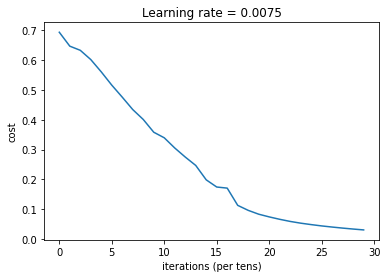

In [16]:
parameters = two_layer_model(train_x, train_y, layers_dims=(n_x, n_h, n_y))

In [17]:
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    Y = Y.reshape(AL.shape)

    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

    current_cache = caches[L-1]
    grads[f"dA{L}"], grads[f"dW{L}"], grads[f"db{L}"] = linear_activation_backward(dAL, current_cache, activation="sigmoid")


    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads[f"dA{str(l + 2)}"], current_cache, activation="relu")
        grads[f"dA{str(l + 1)}"] = dA_prev_temp
        grads[f"dW{str(l + 1)}"] = dW_temp
        grads[f"db{str(l + 1)}"] = db_temp

    return grads

In [18]:
def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2

    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters[f'W{str(l)}'], parameters[f'b{str(l)}'], activation="relu")
        caches.append(cache)

    AL, cache = linear_activation_forward(A, parameters[f'W{str(L)}'], parameters[f'b{str(L)}'], activation="sigmoid")
    caches.append(cache)
    assert(AL.shape == (1,X.shape[1]))

    return AL, caches

In [19]:
def predict(X, y, parameters):
    m = X.shape[1]
    n = len(parameters) // 2
    p = np.zeros((1,m))

    probas, caches = L_model_forward(X, parameters)

    for i in range(probas.shape[1]):
        p[0,i] = 1 if probas[0,i] > 0.5 else 0
    print(f"Accuracy: {str(np.sum((p == y)/m))}")

    return p

In [20]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 0.9999999999999998


In [21]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.72


In [22]:
layers_dims = [12288, 20, 7, 5, 1]

In [23]:
def initialize_parameters_deep(layer_dims):
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)

    for l in range(1, L):
        parameters[f'W{str(l)}'] = np.random.randn(layer_dims[l], layer_dims[l - 1]) / np.sqrt(layer_dims[l - 1])
        parameters[f'b{str(l)}'] = np.zeros((layer_dims[l], 1))

        assert parameters[f'W{str(l)}'].shape == (layer_dims[l], layer_dims[l-1])
        assert parameters[f'b{str(l)}'].shape == (layer_dims[l], 1)


    return parameters

In [24]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    np.random.seed(1)
    costs = []                       

    parameters = initialize_parameters_deep(layers_dims)

    for i in range(num_iterations):
        AL, caches = L_model_forward(X, parameters)

        cost = compute_cost(AL, Y)

        grads = L_model_backward(AL, Y, caches)

        parameters = update_parameters(parameters,  grads, learning_rate)

        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if i % 100 == 0:
            costs.append(cost)
    
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title(f"Learning rate ={str(learning_rate)}")
    plt.show()

    return parameters

Cost after iteration 0: 0.771749
Cost after iteration 100: 0.677781
Cost after iteration 200: 0.661606
Cost after iteration 300: 0.639080
Cost after iteration 400: 0.614008
Cost after iteration 500: 0.585342
Cost after iteration 600: 0.562571
Cost after iteration 700: 0.514817
Cost after iteration 800: 0.465298
Cost after iteration 900: 0.432272
Cost after iteration 1000: 0.412280
Cost after iteration 1100: 0.354945
Cost after iteration 1200: 0.317725
Cost after iteration 1300: 0.291652
Cost after iteration 1400: 0.271591
Cost after iteration 1500: 0.246205
Cost after iteration 1600: 0.230090
Cost after iteration 1700: 0.207156
Cost after iteration 1800: 0.193781
Cost after iteration 1900: 0.195979
Cost after iteration 2000: 0.172805
Cost after iteration 2100: 0.162932
Cost after iteration 2200: 0.154658
Cost after iteration 2300: 0.147815
Cost after iteration 2400: 0.145527
Cost after iteration 2500: 0.137395
Cost after iteration 2600: 0.133099
Cost after iteration 2700: 0.126448
Cost

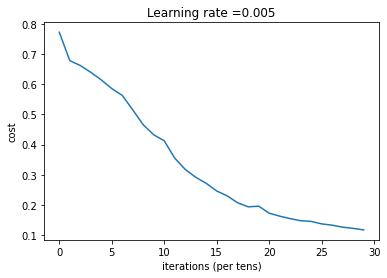

In [25]:
parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate = 0.005, num_iterations = 3000, print_cost = True)

In [26]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9856459330143539


In [27]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.78


In [28]:
def print_mislabeled_images(classes, X, y, p):
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0)
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))

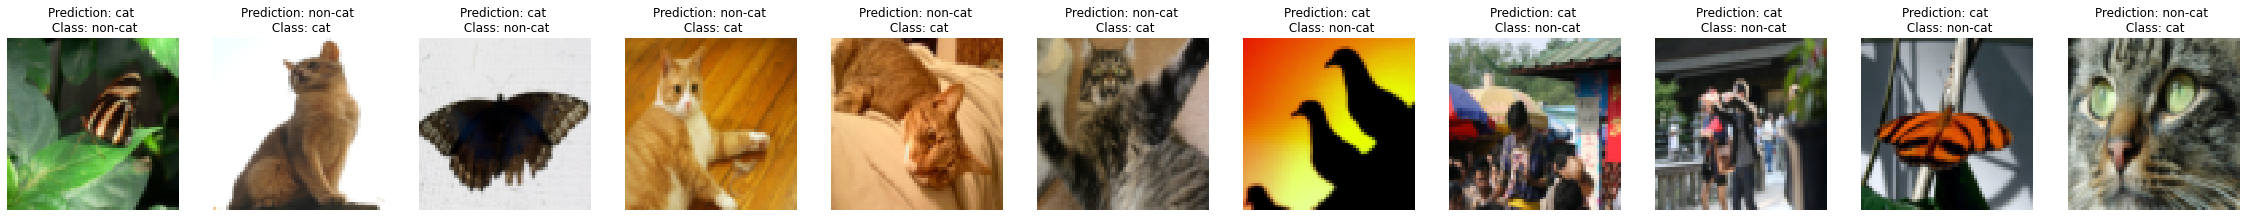

In [29]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

Accuracy: 1.0
y = 1.0, your L-layer model predicts a "cat" picture.


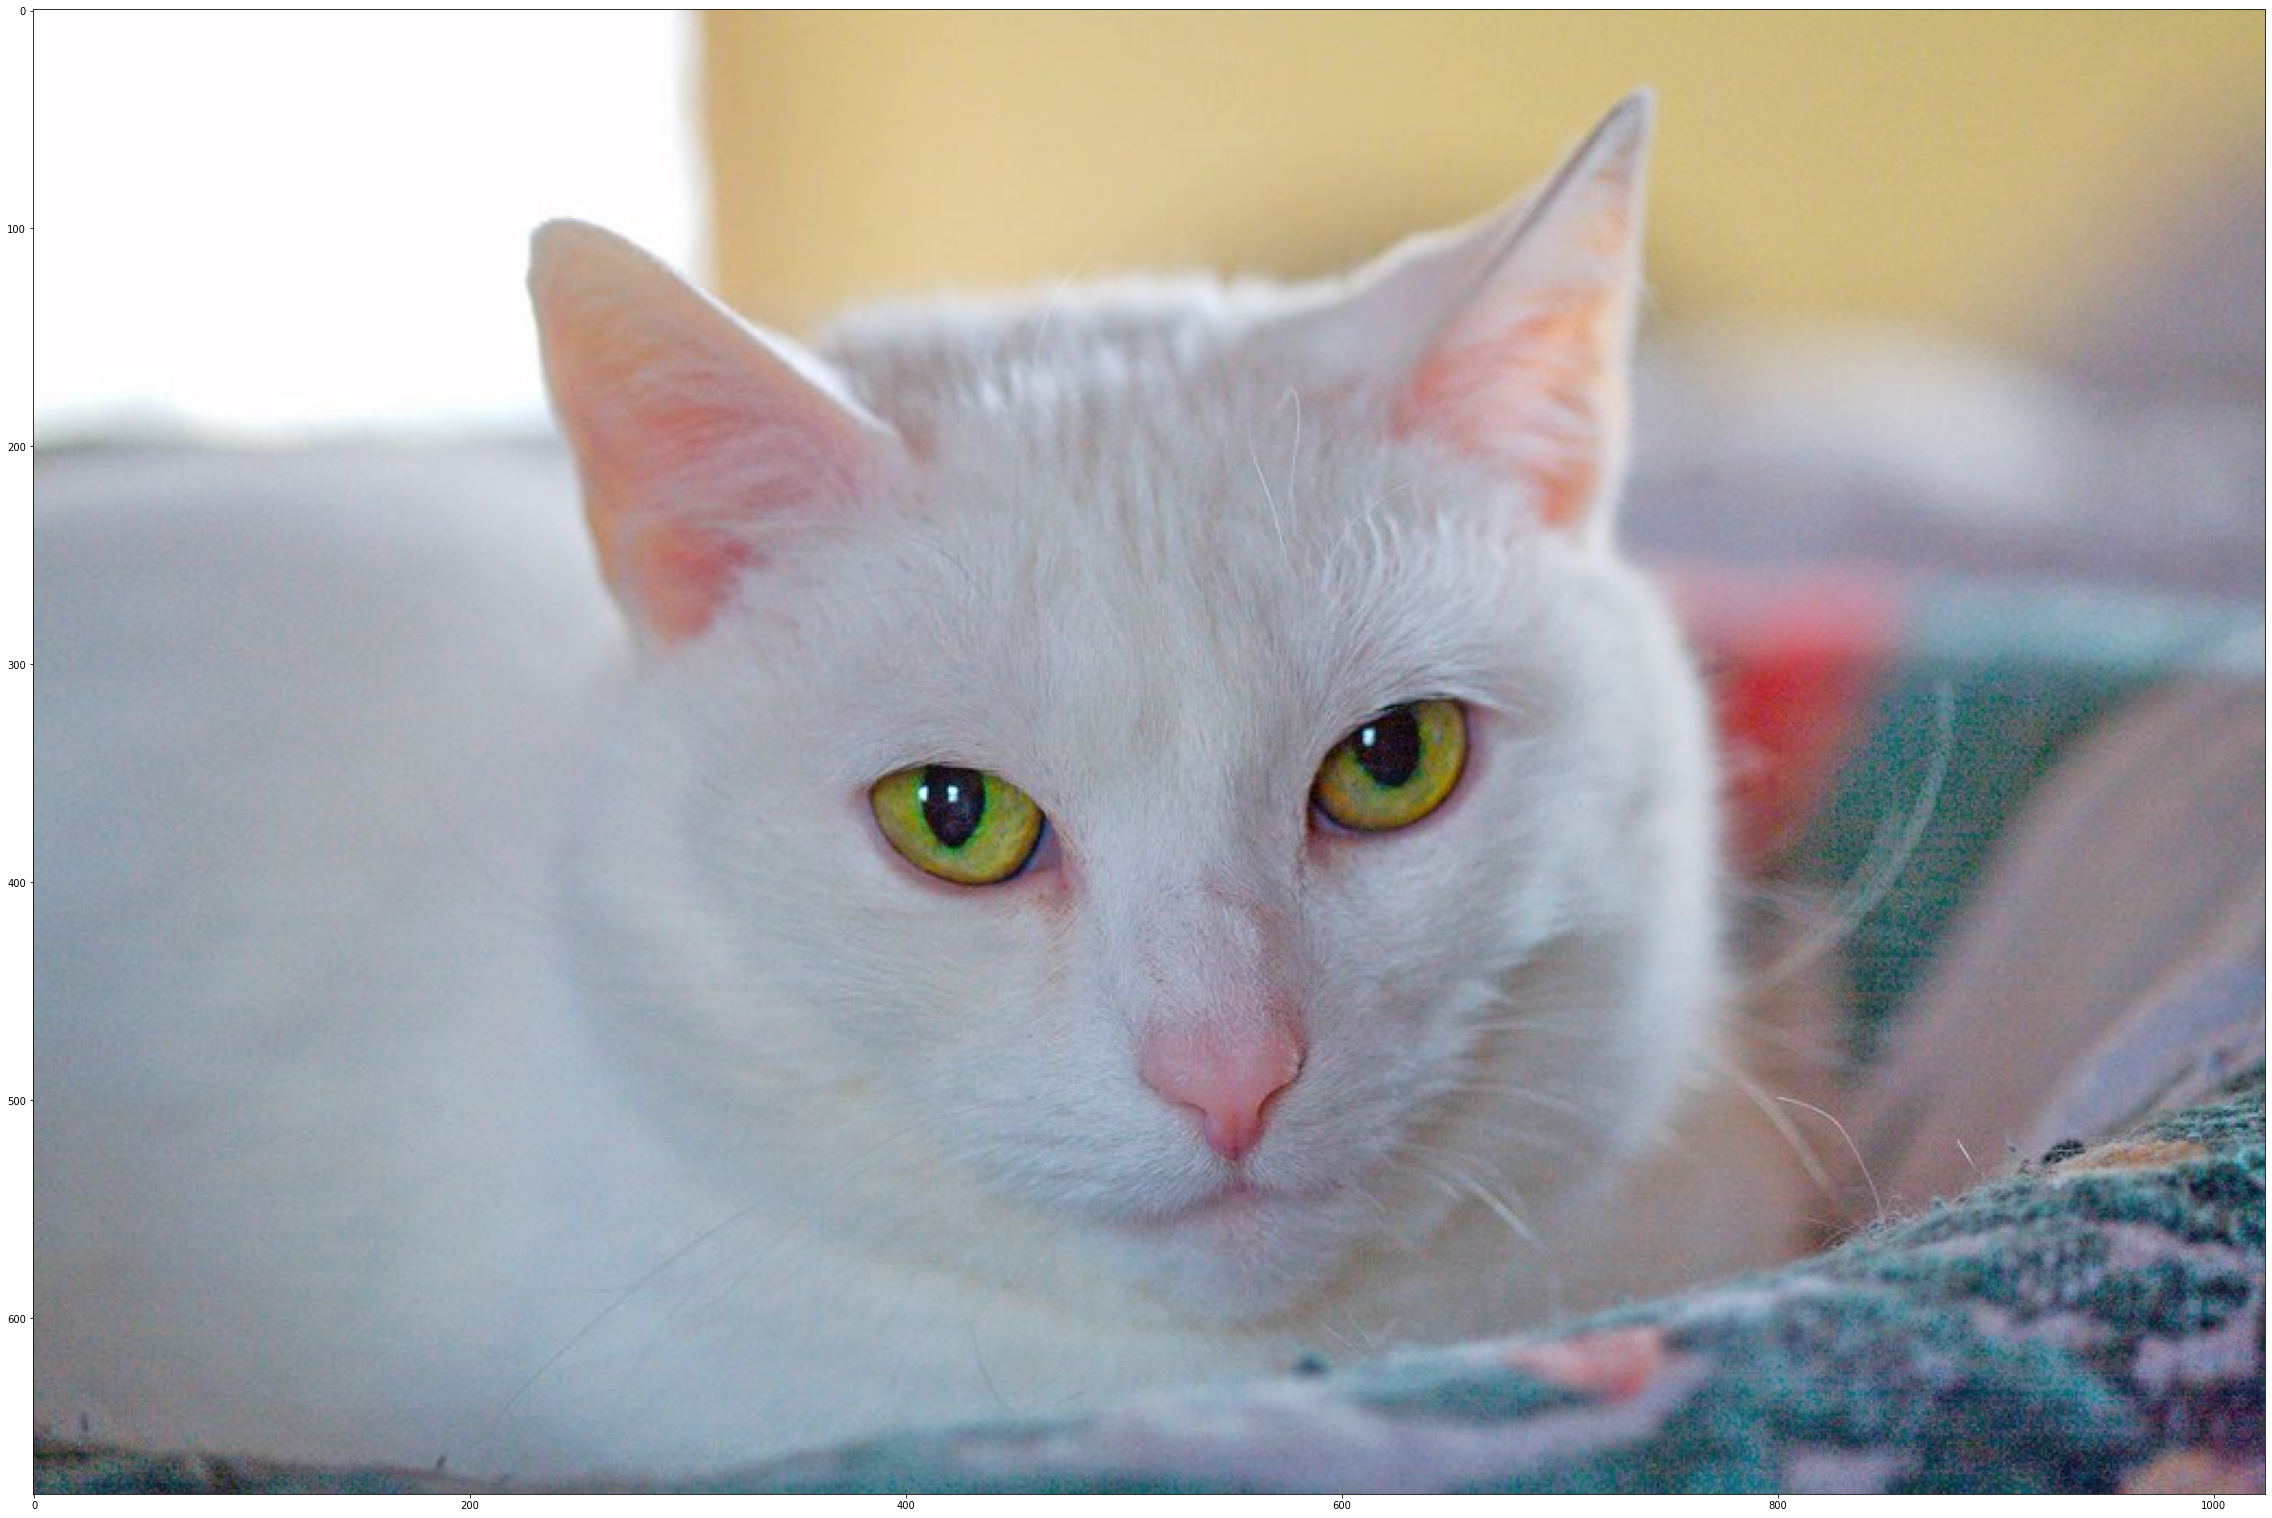

In [30]:
my_image = "my_image.jpg"
my_label_y = [1]

fname = f"images/{my_image}"
image = np.array(imread(fname))
my_image = np.array(Image.fromarray(image).resize((num_px,num_px))).reshape((1, num_px*num_px*3)).T
my_predicted_image = predict(my_image, my_label_y, parameters)

plt.imshow(image)
print(f"y = {str(np.squeeze(my_predicted_image))}" + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") + "\" picture.")